# Module 1 Project

## King County House Sales

## Introduction
<h4> The purpose of this project is to investigate the variables of homes sold in King County, Washington and to develop a model to accurately predict home sale prices. We will be following the OSEMiN model which involves the steps of obtain, scrub, explore, model, and finally interpret. 

## Obtaining the Data
<h4> We will first import all the necessary libaries and modules and then use Pandas to grab the dataset from the kc_house_data.csv and store it as a Pandas Dataframe.


In [117]:
#importing required libraries and setting matplotlib to inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
import sklearn.linear_model as lm
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
%matplotlib inline

In [2]:
#grabbing the dataset
df = pd.read_csv('kc_house_data.csv')

## Scrubbing the Data
<h4> Now we will clean the data to enable us to create our model without errors. First we will drop the 'id', 'date', 'lat', 'long', and 'zipcode' columns as they will not be needed. We will then inspect the dataframe and address the columns will null or missing values.

In [3]:
#dropping id and date columns
df.drop(['id', 'date', 'lat', 'long', 'zipcode'], axis=1, inplace=True)

In [4]:
#viewing the first 15 rows
df.head(15)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_living15,sqft_lot15
0,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,3,7,1180,0.0,1955,0.0,1340,5650
1,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1951,1991.0,1690,7639
2,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0.0,1933,NaN,2720,8062
3,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,1965,0.0,1360,5000
4,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,1987,0.0,1800,7503
5,1230000.0,4,4.50,5420,101930,1.0,0.0,0.0,3,11,3890,1530.0,2001,0.0,4760,101930
6,257500.0,3,2.25,1715,6819,2.0,0.0,0.0,3,7,1715,?,1995,0.0,2238,6819
7,291850.0,3,1.50,1060,9711,1.0,0.0,NaN,3,7,1060,0.0,1963,0.0,1650,9711
8,229500.0,3,1.00,1780,7470,1.0,0.0,0.0,3,7,1050,730.0,1960,0.0,1780,8113
9,323000.0,3,2.50,1890,6560,2.0,0.0,0.0,3,7,1890,0.0,2003,0.0,2390,7570


In [5]:
#checking value in sqft_basement
df.sqft_basement.value_counts()

0.0       12826
?           454
600.0       217
500.0       209
700.0       208
800.0       201
400.0       184
1000.0      148
300.0       142
900.0       142
200.0       105
750.0       104
480.0       103
450.0       103
530.0       103
720.0        98
620.0        90
580.0        84
840.0        83
420.0        81
860.0        79
1100.0       78
670.0        78
780.0        76
550.0        76
650.0        75
240.0        74
380.0        73
680.0        73
360.0        72
          ...  
1275.0        1
2490.0        1
2570.0        1
3260.0        1
266.0         1
2250.0        1
225.0         1
1281.0        1
295.0         1
915.0         1
274.0         1
2730.0        1
1548.0        1
2050.0        1
666.0         1
1798.0        1
556.0         1
417.0         1
1816.0        1
704.0         1
2130.0        1
516.0         1
176.0         1
1913.0        1
1248.0        1
768.0         1
1990.0        1
2720.0        1
475.0         1
2240.0        1
Name: sqft_basement, Len

<h4>There appears to be some values of '?' in sqft_basement. We will replace these with the column mean.</h4>

In [6]:
#replacing missing data in sqft_basement with column mean
sqft_basement_numerical = df.sqft_basement[df.sqft_basement != '?']
sqft_basement_numerical = sqft_basement_numerical.astype(float)
sqft_basement_numerical_mean = round(sqft_basement_numerical.mean(),1)
df['sqft_basement'] = (df['sqft_basement'].map(lambda x: sqft_basement_numerical_mean if x == '?' else x)).astype(float)

In [7]:
#checking for null values
df.isna().sum()

price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
sqft_living15       0
sqft_lot15          0
dtype: int64

<h4>The 'view', 'waterfront', and 'yr_renovated' columns all have null values. We will assume that those homes had no views, are not waterfront, and/or were not renovated and fill those null values with 0.

In [8]:
#replacing null values in waterfront with 0
df['view'] = df['view'].fillna(0)
df['waterfront'] = df['waterfront'].fillna(0)
df['yr_renovated'] = df['yr_renovated'].fillna(0)

<h4> Now before we modify any of the columns we will create a copy of the dataframe to give us an unaltered version to run models on later for comparison. 

In [9]:
#creating copy of df before transformations
df_original = df.copy()

## Exploring the Data
<h4> For this section, we will begin by inspecting the histogram of each variable to look at the distributions and skew.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001517FE98DA0>,
      dtype=object)

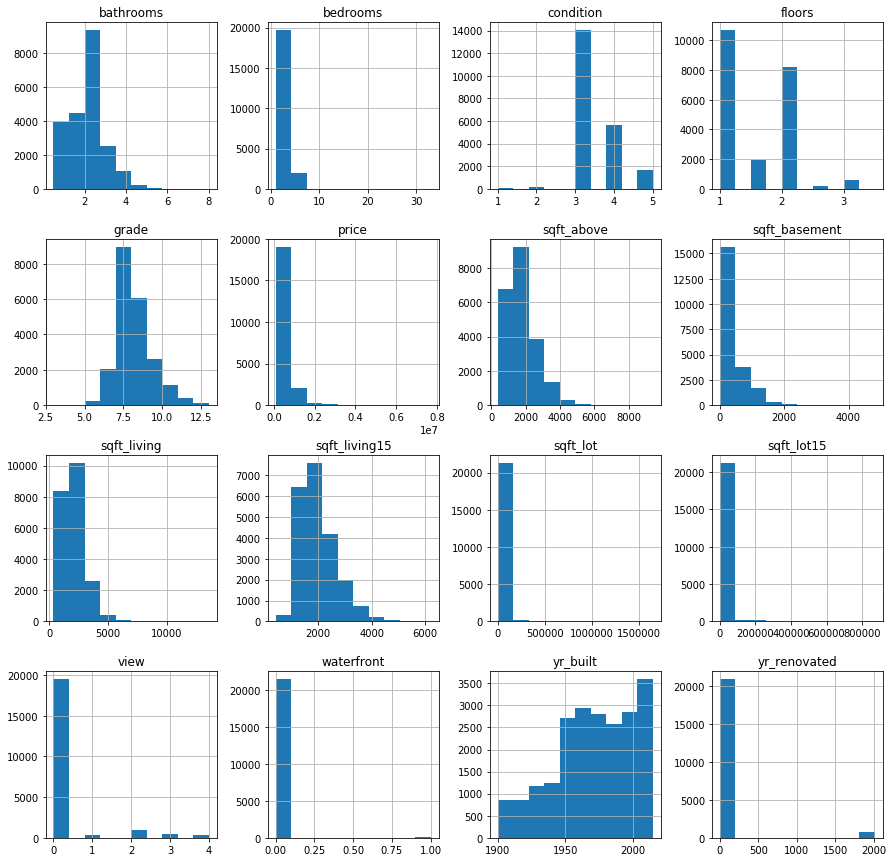

In [10]:
#intial histogram of all variables
df.hist(figsize=(15,15))

<h4> An initial observation of the histograms reveals that nearly none of the variables exhibit a normal distribution and there are outliers in many of the variables. To address these issues, we will iterate through each variable and perform adjustments and transformations in order to give us a more normal distribution.

In [11]:
#checking bedrooms for outliers
df.bedrooms.value_counts()

3     9824
4     6882
2     2760
5     1601
6      272
1      196
7       38
8       13
9        6
10       3
11       1
33       1
Name: bedrooms, dtype: int64

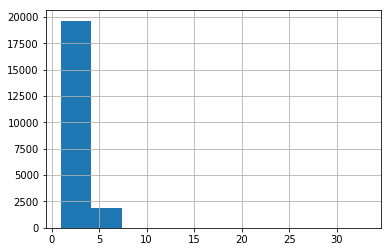

In [12]:
#histogram before removal of outliers
df.bedrooms.hist()

In [13]:
#removing outliers
df.drop(df.index[df['bedrooms'] >= 8], inplace=True)

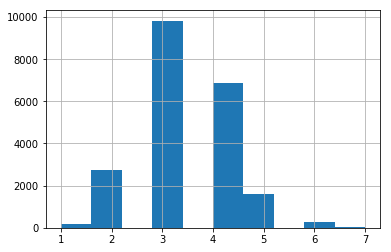

In [14]:
#histogram after removal of outliers
df.bedrooms.hist()

<h6> The 'bedrooms' column had some outliers so all homes with more than 7 bedrooms were removed from the dataframe. The number of homes removed was 24 which represents an insignificant percentage of our total data so removing them should not significantly impact the final model. 

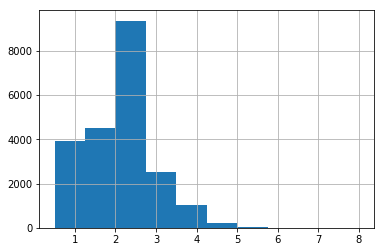

In [15]:
#bathrooms histogram
df.bathrooms.hist()

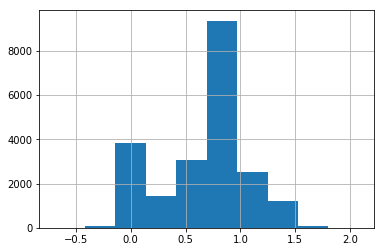

In [16]:
#using log transformation on bathrooms
(np.log(df.bathrooms)).hist()

In [17]:
#transforming bathrooms
df.bathrooms = np.log(df.bathrooms)

<h6> The 'bathrooms' column showed a negatively skewed distribution so we transformed it using a log transformation as the data now exhibits a more normal distribution.

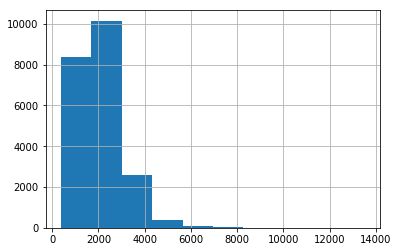

In [18]:
#sqft_living histogram
df.sqft_living.hist()

In [19]:
#checking count of outliers
print(len(df[df.sqft_living > 8000]))
print(len(df[df.sqft_living > 6000]))
print(len(df[df.sqft_living > 4000]))

9
67
773


In [20]:
#removing outliers
df.drop(df.index[df['sqft_living'] > 4000], inplace=True)

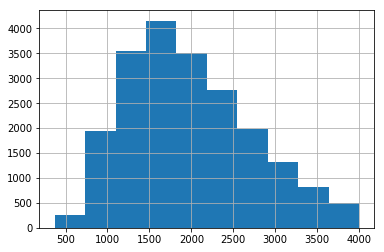

In [21]:
#histogram after removal of outliers
df.sqft_living.hist()

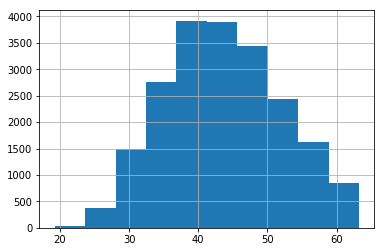

In [22]:
#histogram of square root transformed sqft_living
(np.sqrt(df.sqft_living)).hist()

In [23]:
#square root transformation on sqft_living
df.sqft_living = np.sqrt(df.sqft_living)

<h6> The 'sqft_living' column had some significant outliers. Homes with more than 4000 square feet were removed which was a little over 800 entries. The histogram of the modified data still showed some negative skew so we then performed a square root transformation thus giving us a more normal distribution. 

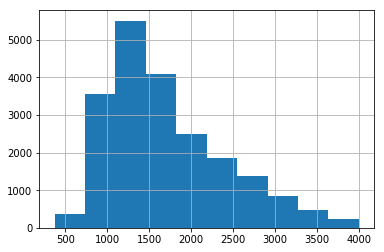

In [24]:
#sqft_above histogram
df.sqft_above.hist()

In [25]:
#square root transformation
df.sqft_above = np.sqrt(df.sqft_above)

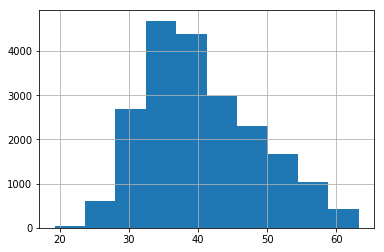

In [26]:
#square root transformed histogram
df.sqft_above.hist()

<h6> The 'sqft_above' column showed a negative skew so we transformed it using a square root transformation to make the distribution more normal.

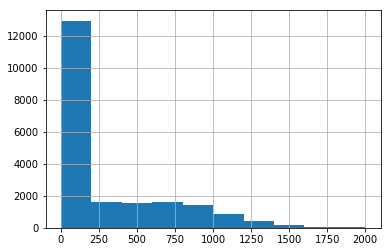

In [27]:
#sqft_basement histogram
df.sqft_basement.hist()

In [28]:
#creating new column that declares whether or not a home has a basement
df['basement'] = df.apply(lambda row: 0 if row.sqft_basement == 0 else 1, axis=1)

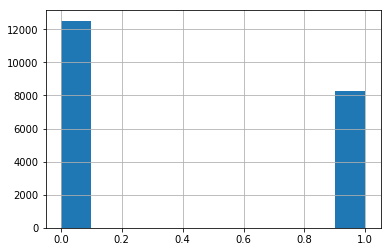

In [29]:
#new binary basement histogram
df.basement.hist()

<h6> The 'sqft_basement' column has a lot of values of 0 which heavily skews the distribution. By creating a new column 'basement' which is binary in nature and declares whether or not a home has a basement, we will better be able to see how this variable affects the home price later on in our model.

In [30]:
#viewing stats of yr_built
df.yr_built.describe()

count    20800.000000
mean      1970.352644
std         29.308936
min       1900.000000
25%       1951.000000
50%       1973.000000
75%       1995.000000
max       2015.000000
Name: yr_built, dtype: float64

In [31]:
#creating new column age that declares the age of the home
df['age'] = (df.yr_built.max() - df.yr_built + 1)

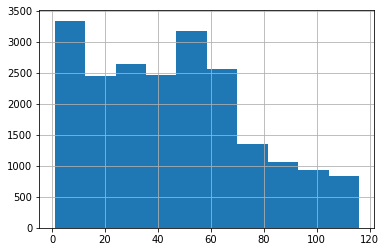

In [32]:
#histogram of new age column
df.age.hist()

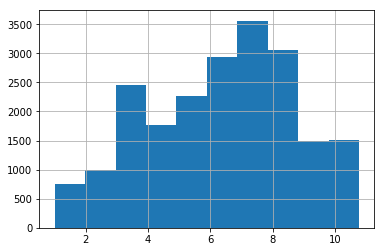

In [33]:
#square root transformation on age
df.age = np.sqrt(df.age)
df.age.hist()

In [34]:
#removal of old yr_built column
df.drop('yr_built',axis=1,inplace=True)

<h6> The 'yr_built' column did not make a lot of sense to have in its current state as it represents the age of the home but in terms of the year built. To remedy this we created a new column 'age' which subtracts the year the home was built from the most recent year in the data - 2015. A value of 1 was also added to the age in order to allow us to transform it without error.

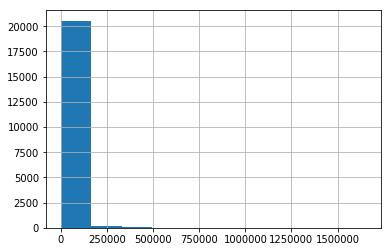

In [35]:
#sqft_lot histogram
df.sqft_lot.hist()

In [36]:
#checking number of outliers
len(df[df.sqft_lot>200000])

213

In [37]:
#removal of outliers
df.drop(df.index[df['sqft_lot'] > 200000], inplace=True)

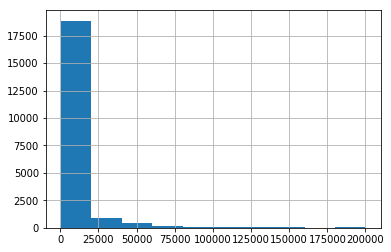

In [38]:
#histogram after removal of outliers
df.sqft_lot.hist()

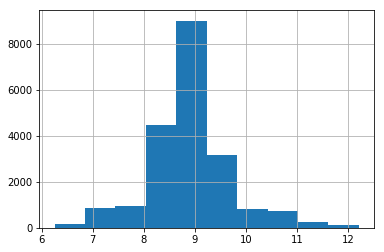

In [39]:
#log transformation of sqft_lot
df.sqft_lot = np.log(df.sqft_lot)
df.sqft_lot.hist()

<h6> For the 'sqft_lot' column, we first had to remove some of the outliers (213 values) and then performed a log transformation on the data to normalize the distribution.

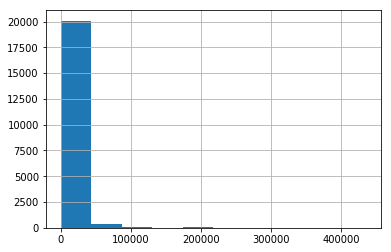

In [40]:
#histogram of sqft_lot15
df.sqft_lot15.hist()

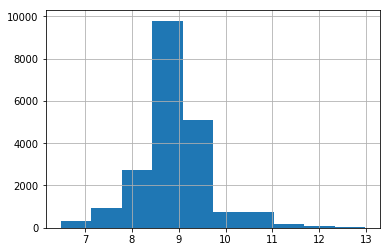

In [41]:
#log transformed sqft_lot15
df.sqft_lot15 = np.log(df.sqft_lot15)
df.sqft_lot15.hist()

<h6> Similarly to the 'sqft_lot' column, we performed a log transformation on the 'sqft_lot15' column to normalize the distribution. 

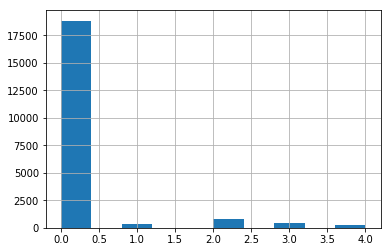

In [42]:
#view histogram
df.view.hist()

In [43]:
#unique values of view
df.view.unique()

array([0., 3., 4., 2., 1.])

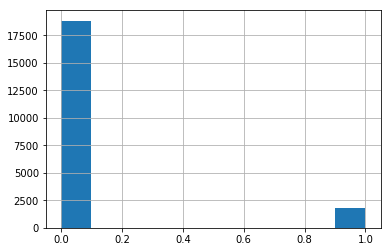

In [44]:
#converting all view values above 0 to 1 to signify that the home has been viewed
df['viewed'] = df.view
i = 4
while i > 0:
    df.viewed = df.viewed.replace(i, 1)
    i -= 1
df.viewed.hist()

<h6> The 'view' column only contains values 0, 1, 2, 3 and 4 with most of the values being 0. To better represent this data, an additional column was added which tells us whether or not a home was view, represented by a 1 or 0. 

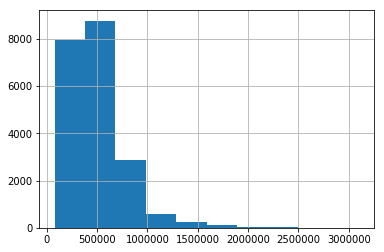

In [45]:
#price histogram
df.price.hist()

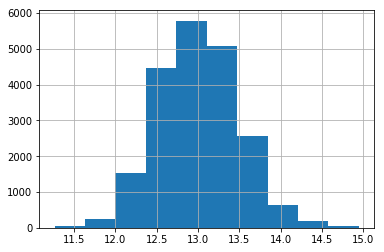

In [46]:
#log transformation on price
df.price = np.log(df.price)
df.price.hist()

<h6> Finally, we perform a log transformation on our dependent variable 'price' in order to normalize its distribution. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000015107C12898>,
      dtype=object)

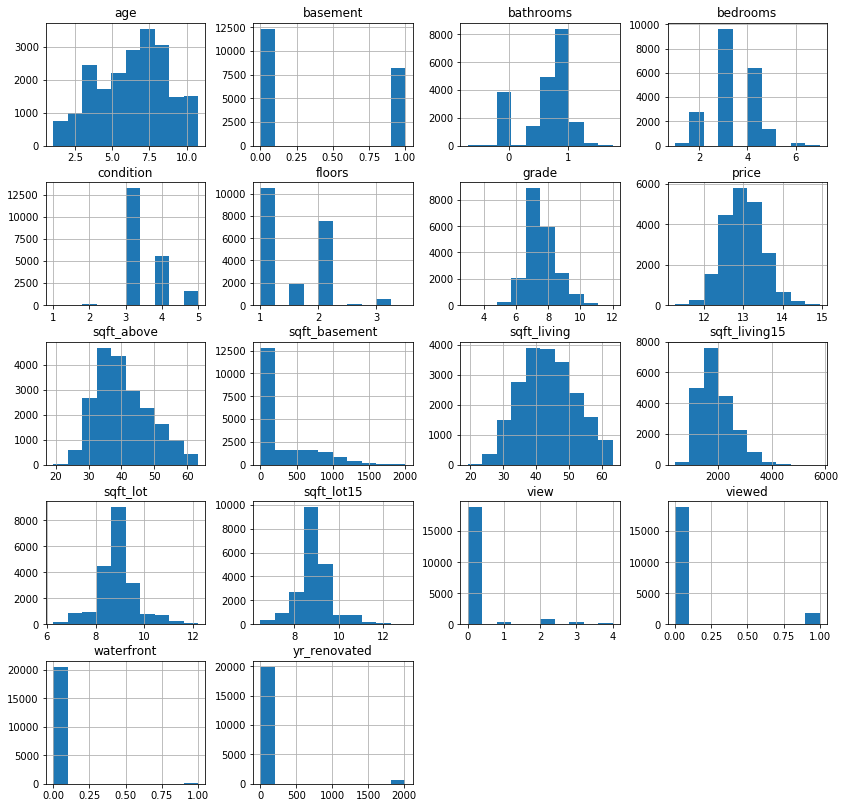

In [47]:
#updated histogram of all variables after transformations and adjustments
df.hist(figsize=(14,14))

<h6> Above we can see all of the updated histograms for our variables. Many of the distributions are now normal apart from our created binary columns and their original counterparts.

## Model the Data
<h4> Now it is time to create a model for our data. We will be using the function 'stepwise_selection' below to rank the predictors of our data on their contribution to the model and to find the best number of predictors to use.

In [48]:
#stepwise selection function
import statsmodels.api as sm

def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

<h6> We will now split our data into a train and test set using an initial test size of 0.25. We will then use the stepwise function above to do an interative feature selection for all of the independent variables. For each iteration, one more predictor will be selected and added, and in addition, a repeated k-fold with 3 splits and 10 repeats will be ran to cross validate the R-squared value and % difference in MSE between the train and test set for each regression.
Then, by graphing a plot of our predicted y-values vs the actual y-values and comparing the R-squared values and % differences in MSE, we should be able to decide which predictors to include in our model of best fit. 

C:\Users\sparr\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\sparr\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\sparr\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)

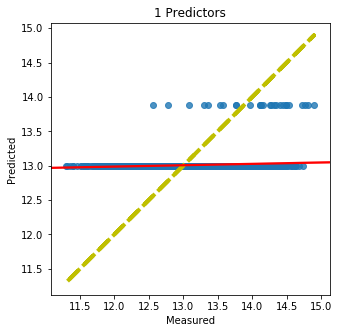

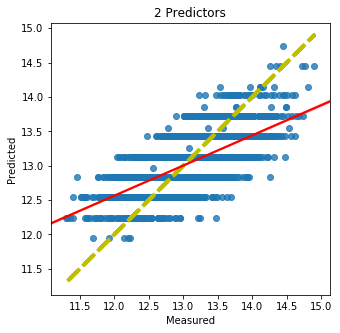

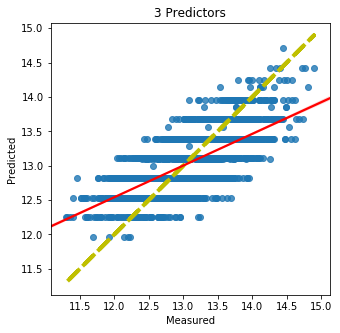

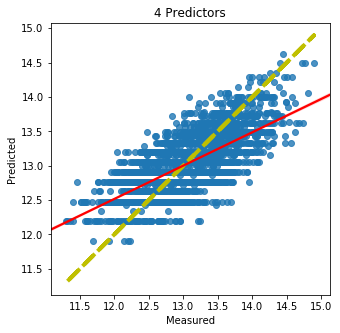

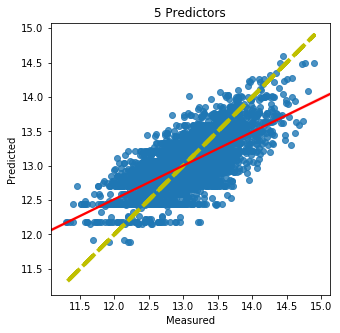

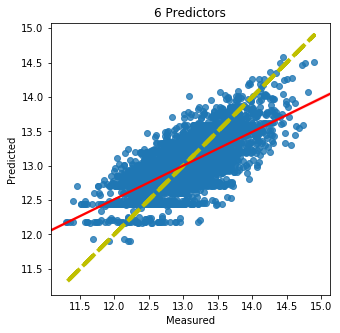

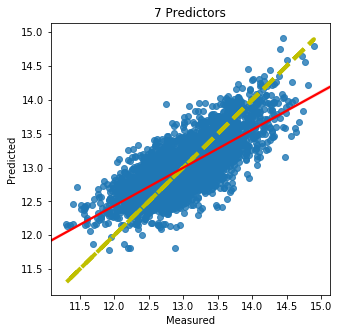

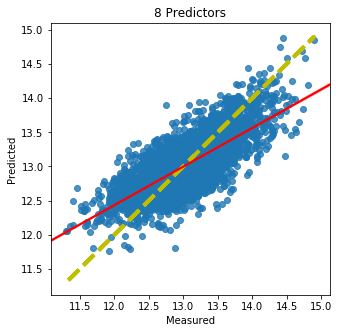

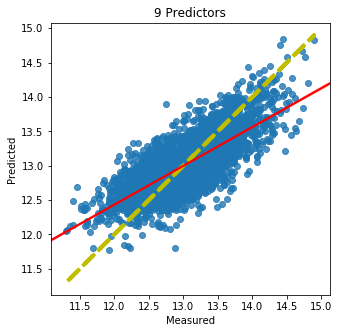

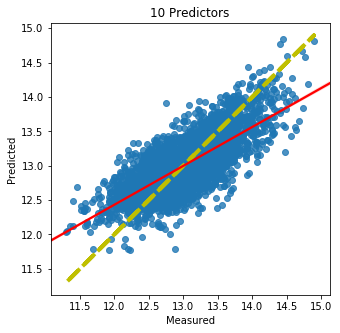

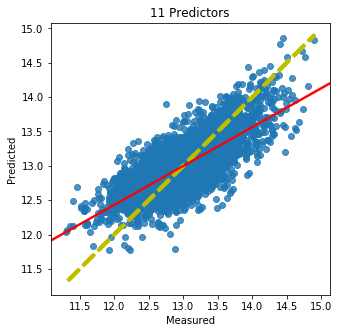

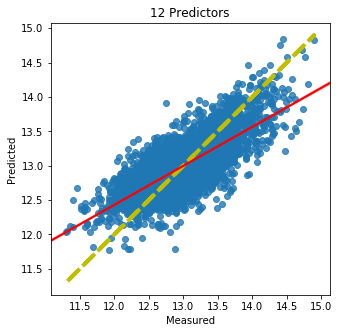

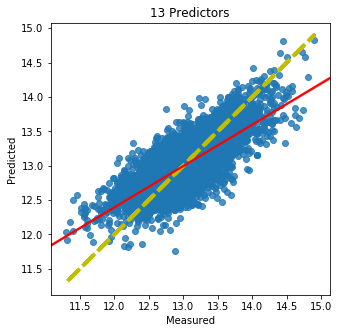

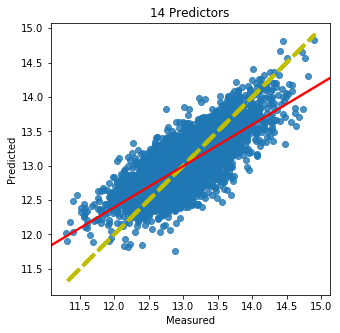

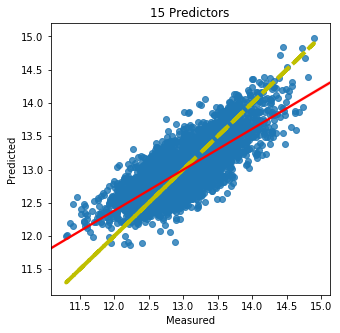

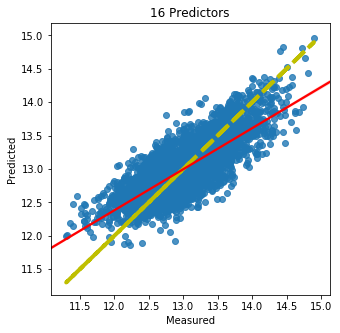

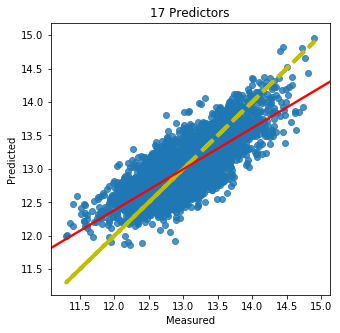

,# Predictors,R-squared,MSE % Difference,Added Predictor
0,1,0.036134,2.199824,[waterfront]
1,2,0.359981,0.310695,[grade]
2,3,0.466462,-0.291725,[viewed]
3,4,0.488875,-0.677404,[basement]
4,5,0.493260,-0.908497,[bathrooms]
5,6,0.502196,-1.024947,[floors]
6,7,0.567091,-2.004043,[age]
7,8,0.569330,-2.005376,[condition]
8,9,0.570227,-1.993097,[view]
9,10,0.570808,-1.908180,[sqft_lot15]


In [92]:
#RFE regression of all predictors using repeated k-fold 
from sklearn.model_selection import RepeatedKFold

#setting X, y and creating train/test split
X = df.drop('price', axis=1)
y = df.price
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=47)

#initializing counter variable 'i' and creating lists to add to over each iteration
i = 1
results_df = pd.DataFrame()
predictors = list()
reg_score = list()
mse_diffs = list()
added_pred = list()
previous_columns = []

#this loop repeats once for each column in 'df'
while i <= (int(len(df.drop('price', axis=1).columns))):
    rkf = RepeatedKFold(n_splits=3, n_repeats=10, random_state=47)
    scores = 0
    percent_diffs = 0
    
    #this loop using a repeated k-fold to generate an average R-squared and % difference in train/test MSE 
    for train_index, test_index in rkf.split(X_train):
        X_train2, X_val = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train2, y_val = y_train.iloc[train_index], y_train.iloc[test_index]
        linreg = LinearRegression()
        selector = RFE(linreg, n_features_to_select = i)
        selector = selector.fit(X_train2, y_train2) 
        selected_columns = X_train2.columns[selector.support_ ]
        linreg.fit(X_train2[selected_columns],y_train2)
        scores = scores + linreg.score(X_test[selected_columns], y_test)
        y_hat_train = linreg.predict(X_train[selected_columns])
        y_hat_test = linreg.predict(X_test[selected_columns])
        train_mse = mean_squared_error(y_train, y_hat_train)
        test_mse = mean_squared_error(y_test, y_hat_test)
        mse_diff = test_mse - train_mse
        percent_diff = mse_diff/train_mse
        percent_diffs += percent_diff
        
    #adding data to lists
    predictors.append(i)
    reg_score.append(scores/30)
    mse_diffs.append(percent_diffs/30*100)
    added_pred.append(list(set(selected_columns) - set(previous_columns)))
    previous_columns = selected_columns
    predicted = linreg.predict(X_test[selected_columns])

    #creating a plot of predicted values vs actual values
    fig, ax = plt.subplots(figsize=(5,5))
    #ax.scatter(y_test, predicted, edgecolors=(0, 0, 0))
    ax.plot(y_test, y_test, 'k--', lw=4, color='y')
    sns.regplot(x=y_test, y=predicted, ax=ax, line_kws={"color": "red"})
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    ax.set_title(str(i) + " Predictors")    
    i += 1
results_df['# Predictors'] = predictors
results_df['R-squared'] = reg_score
results_df['MSE % Difference'] = mse_diffs
results_df['Added Predictor'] = added_pred
plt.show()
results_df

<h6> From the above table, we can see that the test set MSE is anywhere from approx 2% more to 3% less than the training set MSE. This varies slightly as more predictors are added and doesn't follow a pattern unlike the R-squared values which increases with each additional predictor. Looking at the generated plots of measured vs predicted values for 'price', we can see that as more predictors are added, the predicted values approach the measured values. Based on these findings, we will use all 17 predictors in our model as that will maximize our R-squared value of the model against our test data and also will maintain a moderately low difference in MSE between the train and test set. 

<h6> Now we will look at the coefficients of our regression model. Since our dependent variable 'price' was log transformed, we will reverse that transformation for each of the coefficients in order to be able to talk about them in terms of real-life values. We will also sort the coefficients in descending order to rank the significance of each predictor.

In [120]:
#creates a dataframe of both log transformed and non-log transformed coefficients of predictors in model
X = df.drop('price', axis=1)
y = df.price
model_reg = lm.LinearRegression()
linreg.fit(X, y)
model_coef = pd.DataFrame()
preds = list()
coef_log = list()
coef = list()
i = 0
for col in X.columns:
    preds.append(X.columns.values[i])
    coef_log.append(linreg.coef_[i])
    coef.append(10**(linreg.coef_[i]))
    i += 1
model_coef['Predictor'] = preds
model_coef['Coefficient(log)'] = coef_log
model_coef['Coefficient'] = coef
model_coef.sort_values(by=['Coefficient'], ascending=False)

,Predictor,Coefficient(log),Coefficient
5,waterfront,0.400170,2.512872
8,grade,0.192811,1.558873
14,basement,0.082538,1.209310
4,floors,0.078084,1.196973
1,bathrooms,0.067054,1.166954
15,age,0.064526,1.160182
7,condition,0.050389,1.123023
16,viewed,0.043601,1.105606
6,view,0.029136,1.069390
2,sqft_living,0.012926,1.030210


<h6> From the above table we can see the relative impact of each predictor with 'waterfront' being the most significant and 'sqft_lot15' being the least signficant. 

## Evaluate the Model
<h4> Now that we have our model, we can begin to ask relevant questions as to the effectiveness and fit of the model as well as address concerns and investigate possible improvements.

## Question 1
### How does our model compare to a model of the data before any of our modifications and transformations?

<h6> Before we started to dig into and modify our data set, we grabbed a copy of an unedited version of the data - 'df_orig'. We can run a regression on that dataset and compare the results to those of our model to answer this question. We will repeat the stepwise feature selection as we did earlier, using a repeated k-fold validation method, and plotting the predicted values vs the actual values.

C:\Users\sparr\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\sparr\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\sparr\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)

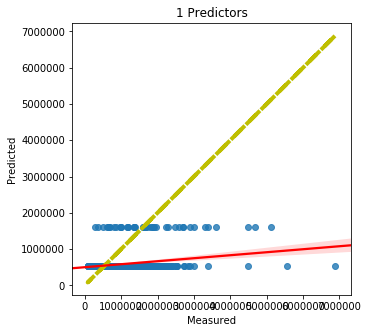

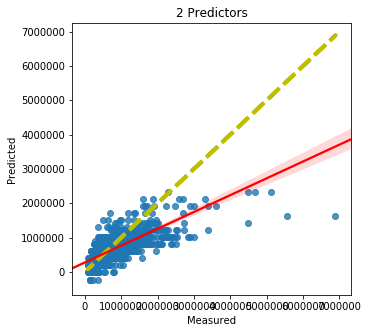

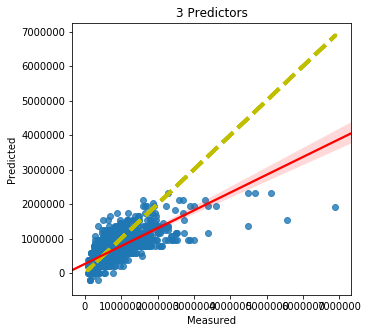

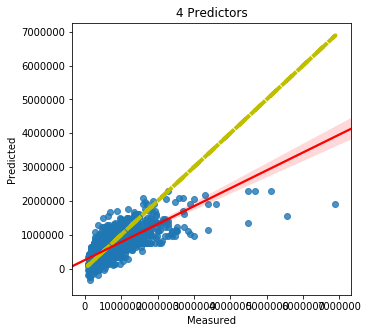

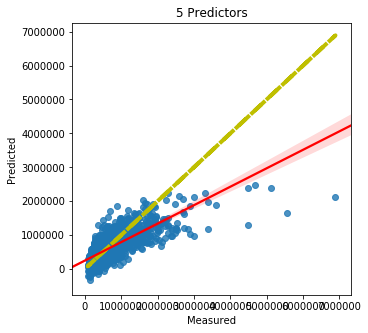

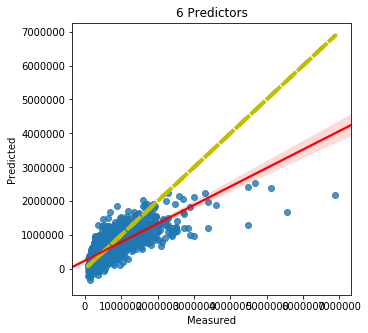

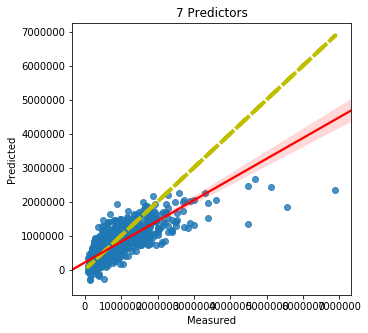

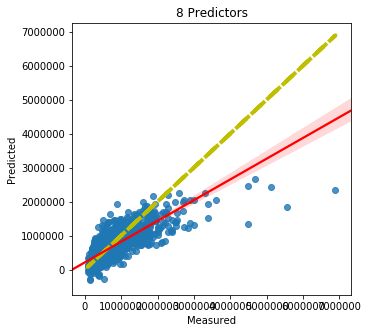

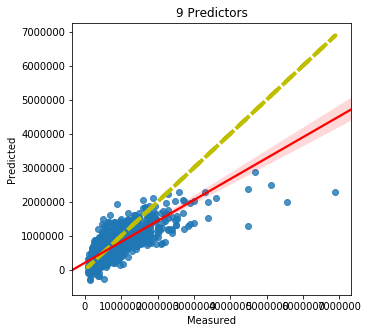

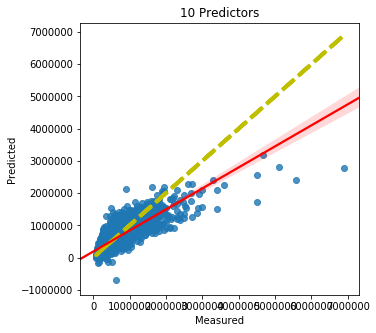

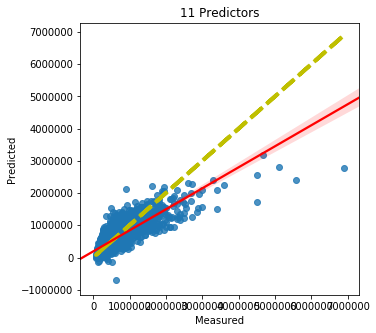

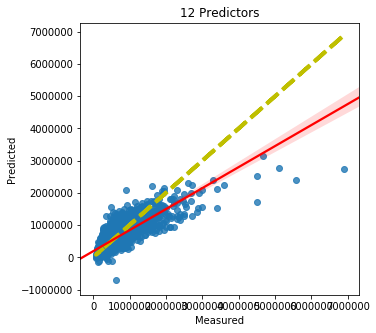

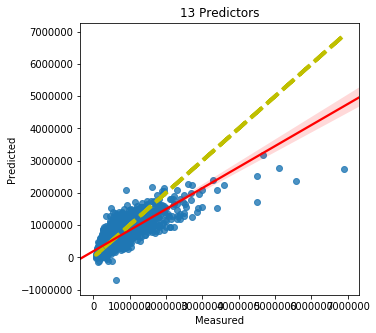

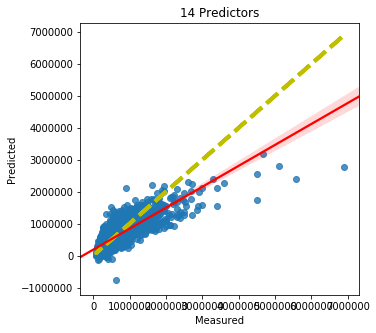

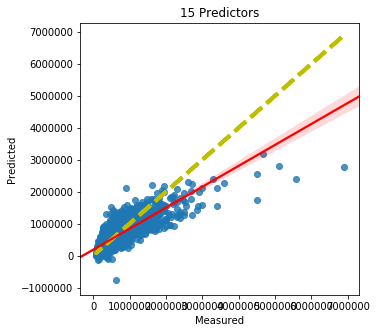

,# Predictors,R-squared,MSE % Difference,Added Predictor
0,1,0.100510,-0.198471,[waterfront]
1,2,0.490020,4.409659,[grade]
2,3,0.515821,5.126805,[view]
3,4,0.525980,6.090957,[condition]
4,5,0.540883,5.089502,[bathrooms]
5,6,0.543076,5.013684,[floors]
6,7,0.600565,4.493230,[yr_built]
7,8,0.609256,4.418562,[bedrooms]
8,9,0.630056,4.366307,[sqft_basement]
9,10,0.650623,4.656122,[sqft_above]


In [98]:
#RFE regression of all predictors using repeated k-fold 
from sklearn.model_selection import RepeatedKFold

#setting X, y and creating train/test split
X = df_original.drop('price', axis=1)
y = df_original.price
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=47)

#initializing counter variable 'i' and creating lists to add to over each iteration
i = 1
results_df_original = pd.DataFrame()
predictors = list()
reg_score = list()
mse_diffs = list()
added_pred = list()
previous_columns = []

#this loop repeats once for each column in 'df'
while i <= (int(len(df_original.drop('price', axis=1).columns))):
    rkf = RepeatedKFold(n_splits=3, n_repeats=10, random_state=47)
    scores = 0
    percent_diffs = 0
    
    #this loop using a repeated k-fold to generate an average R-squared and % difference in train/test MSE 
    for train_index, test_index in rkf.split(X_train):
        X_train2, X_val = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train2, y_val = y_train.iloc[train_index], y_train.iloc[test_index]
        linreg = LinearRegression()
        selector = RFE(linreg, n_features_to_select = i)
        selector = selector.fit(X_train2, y_train2) 
        selected_columns = X_train2.columns[selector.support_ ]
        linreg.fit(X_train2[selected_columns],y_train2)
        scores = scores + linreg.score(X_test[selected_columns], y_test)
        y_hat_train = linreg.predict(X_train[selected_columns])
        y_hat_test = linreg.predict(X_test[selected_columns])
        train_mse = mean_squared_error(y_train, y_hat_train)
        test_mse = mean_squared_error(y_test, y_hat_test)
        mse_diff = test_mse - train_mse
        percent_diff = mse_diff/train_mse
        percent_diffs += percent_diff
        
    #adding data to lists
    predictors.append(i)
    reg_score.append(scores/30)
    mse_diffs.append(percent_diffs/30*100)
    added_pred.append(list(set(selected_columns) - set(previous_columns)))
    previous_columns = selected_columns
    predicted = linreg.predict(X_test[selected_columns])

    fig, ax = plt.subplots(figsize=(5,5))
    #ax.scatter(y_test, predicted, edgecolors=(0, 0, 0))
    ax.plot(y_test, y_test, 'k--', lw=4, color='y')
    sns.regplot(x=y_test, y=predicted, ax=ax, line_kws={"color": "red"})
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    ax.set_title(str(i) + " Predictors")    
    i += 1
results_df_original['# Predictors'] = predictors
results_df_original['R-squared'] = reg_score
results_df_original['MSE % Difference'] = mse_diffs
results_df_original['Added Predictor'] = added_pred
plt.show()
results_df_original

<h6> From the above output, it would appear that including all 17 predictors gives the highest R-squared value so we will continue with our model by using all predictors. 

<h6> Now we will determine the best test size to use for our model by plotting the divergence of the mean squared error vs train/test ratio.

In [ ]:
#plotting the divergence of mean squared error as train/test ratio increases
X = df.drop('price', axis=1)
y = df.price
train_err = []
test_err = []
t_sizes = list(range(5,100,5))
for t_size in t_sizes:
    temp_train_err = []
    temp_test_err = []
    for i in range(100):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=t_size/100)
        linreg.fit(X_train, y_train)
        y_hat_train = linreg.predict(X_train)
        y_hat_test = linreg.predict(X_test)
        temp_train_err.append(mean_squared_error(y_train, y_hat_train))
        temp_test_err.append(mean_squared_error(y_test, y_hat_test))
    train_err.append(np.mean(temp_train_err))
    test_err.append(np.mean(temp_test_err))
plt.scatter(t_sizes, train_err, label='Training Error')
plt.scatter(t_sizes, test_err, label='Testing Error')
plt.legend()

In [ ]:
from sklearn.model_selection import RepeatedKFold
rkf = RepeatedKFold(n_splits=2, n_repeats=10, random_state=47)
X = df.drop('price', axis=1)
y = df.price
for train_index, test_index in rkf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    linreg = LinearRegression()
    selector = RFE(linreg, n_features_to_select = 17)
    selector = selector.fit(X_train, y_train) 
    selected_columns = X_train.columns[selector.support_ ]
    linreg.fit(X_train[selected_columns],y_train)
    print(linreg.score(X_test, y_test))

In [ ]:
#choosing a slightly different train/test split size
linreg = LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=47)
selector = RFE(linreg, n_features_to_select = 17)
selector = selector.fit(X_train, y_train) 
selected_columns = X_train.columns[selector.support_ ]
linreg.fit(X_train[selected_columns],y_train)
print(linreg.score(X_test, y_test))

In [ ]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor(random_state=47)
forest_reg.fit(X_train, y_train)
print('Random Forest R squared": %.4f' % forest_reg.score(X_test, y_test))

In [ ]:
from sklearn import ensemble
from sklearn.ensemble import GradientBoostingRegressor
model = ensemble.GradientBoostingRegressor()
model.fit(X_train, y_train)
print('Gradient Boosting R squared": %.4f' % model.score(X_test, y_test))

In [ ]:
#least squares regression with OLS
import statsmodels.api as sm
model = sm.OLS(y_train,X_train)
results = model.fit()
results.summary()

In [ ]:
#calculating mean squared error again
from sklearn.metrics import mean_squared_error

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)

print('Train Mean Squared Error:', train_mse)
print('Test Mean Squared Error:', test_mse)

In [ ]:
#initial linear regression with all variables
X = df.drop('price', axis=1)
y = df.price
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=47)
linreg = LinearRegression()
linreg.fit(X_train,y_train)

In [ ]:
#checking MSE of initial regression
y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)

print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)

In [ ]:
#using cross validation to check average mean squared error
cv_mse = cross_val_score(linreg, X_test, y_test, cv=100, scoring="neg_mean_squared_error")
print("Average Negative Mean Squared Error: %0.2f (+/- %0.2f)" % (cv_mse.mean(), cv_mse.std() * 2))

In [ ]:
#using cross validation to check average R-squared value
cv_rsquared = cross_val_score(linreg, X_test, y_test, cv=100)
print("Average R-squared Value: %0.2f (+/- %0.2f)" % (cv_rsquared.mean(), cv_rsquared.std() * 2))

In [ ]:
#heatmap to check for correlations between variables
sns.heatmap(df.corr(), center=0);
plt.rcParams['figure.figsize']=(12,12)

In [ ]:
#creating dataframe that will remove some of the variables with high correlation to other variables
#df_adj = df
#to_drop = ['view', 'sqft_lot15', 'sqft_above', 'sqft_basement']
#df_adj.drop(to_drop, axis=1, inplace=True)

In [ ]:
#regression of new dataset
linreg = LinearRegression()
X = df_adj.drop('price', axis=1)
y = df_adj.price
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=47)
selector = RFE(linreg, n_features_to_select = 14)
selector = selector.fit(X_train, y_train) 
selected_columns = X_train.columns[selector.support_ ]
linreg.fit(X_train[selected_columns],y_train)
print(linreg.score(X_test, y_test))

In [ ]:
#least squares regression with OLS
import statsmodels.api as sm
model = sm.OLS(y_train,X_train)
results = model.fit()
results.summary()

In [ ]:
#heatmap to check for correlations between variables
sns.heatmap(df_adj.corr(), center=0);
plt.rcParams['figure.figsize']=(12,12)